# Loss Functions

When fitting data to labels we need to measure the degree of goodness of fit. This sounds obvious but isn't quite so straightforward. In fact, there are entire fields of statistics that focus solely on that (e.g. robust statistics). In this notebook we'll discuss a number of ways how we can measure whether our model is doing well. As a side-benefit, we'll get to know the loss function layers in ``gluon``. We begin with our default import ritual.

In [1]:
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np
import mxnet.autograd as ag
import math
mx.random.seed(1)

# Regression 

## L1 loss

As we discussed in the introduction, regression describes the cases where we want to estimate some real valued number $f(x) \in \mathbb{R}$ to match an observation $y$. A natural idea of measuring the distance would be to compute $|y - f(x)|$. This makes sense, e.g. if we need to estimate how much it might cost to manufacture a product: if we estimate too low, we will incur a loss due to underestimation. If we overprice it, we will sell fewer products (here we're making the unrealistic assumption that both are equally bad). In math, the loss function is

$$l(y,f) = |y-f|$$

Let's compute it with ``gluon`` and also its gradient. 

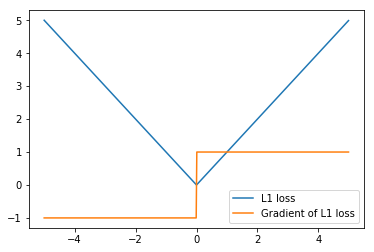

In [2]:
loss = gluon.loss.L1Loss()

# getting data ready
output = nd.arange(-5,5,0.01)
output.attach_grad() # we need the gradient
thelabel = nd.zeros_like(output) 
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L1 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L1 loss')
plt.legend()
plt.show()

Before we move on to other losses, let's quickly consider what happens if we want to minimize the L1 loss. Consider the toy example where we have a number of labels $y_i$ and we want to fit *all* of them to a single scalar, say $f$. In this case we need to solve the minimization problem:

$$\mathop{\mathrm{minimize}}_f \sum_i |y_i - f|$$

As we saw above, the gradient is either -1 or 1. Hence, for the gradients to the left and to the right of $f$ to cancel out we need *the same number of $y_i$* on either side. This is the definition of the *median*. Hence, minimizing the L1 loss means that we are computing the median (at least for constant predictions). In general, the L1 loss is very robust against outliers, since the gradients can never get too large. 

## L2 loss

Taking the squared distance between observation and estimate tends to be the default choice in many problems. Often for convenience we multiply this loss by a factor of $\frac{1}{2}$ to ensure that the derivatives look pretty. Here's the loss:

$$l(y,f) = \frac{1}{2} (y-f)^2$$

For vectorial $f$ and $y$ this is the squared Euclidean distance between points. The L2 loss has a few other nice properties. By a similar argument as before we can see that $\sum_{i=1}^m \frac{1}{2} (y_i - f)^2$ is minimized by choosing $f = \frac{1}{m} \sum_{i=1}^m y_i$, i.e. by choosing the mean. Let's see what it looks like in practice.

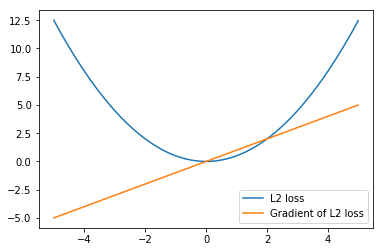

In [3]:
loss = gluon.loss.L2Loss()

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L2 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L2 loss')
plt.legend()
plt.show()

## Huber's Robust loss

Huber's Robust Loss is a cross between the L1 and the L2 loss. It behaves like an L2 loss close to zero. Beyond that, for discrepancies larger than $\rho$ it behaves like an L1 loss. The scaling is set up in such a way as to ensure that the derivative is continuous. 

$$l(y,f) = \begin{cases}
\frac{1}{2 \rho} (y-f)^2 & \text{ for } |y-f| < \rho \\
|y-f| - \frac{\rho}{2} & \text{ otherwise}
\end{cases}$$

If we minimize the loss something interesting happens (again, we're in the toy scenario that we just estimate a scalar). The number of cases with $y_i < f-\rho$ and with $y_i > f+\rho$ are going to cancel out, since their gradients are all $-1$ and $1$ respectively. For all the $y_i$ closer to $f$, the gradients will balance out like in the L2 loss case. In other words, $f$ will be the mean for all points closer than $\rho$. This is pretty much what a *trimmed mean* estimator does. It ensures that a few outliers (very large $|y_i|$) won't break the estimate. Let's check it out in practice.

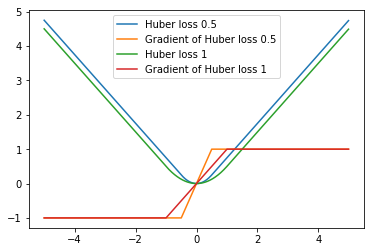

In [4]:
loss = gluon.loss.Huber(rho=0.5)

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Huber loss 0.5')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Huber loss 0.5')

# and now for the same loss function with rho=1.0, the default
loss = gluon.loss.Huber()

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Huber loss 1')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Huber loss 1')

plt.legend()
plt.show()

## Quantile Regression

In most cases we want to find an output $y$ which is in some way maximal for a given $x$, e.g. the one with the smallest amount of variance, the most likely one, etc. But there are cases where this isn't quite the most desirable thing: imagine that we want to build a tool for physicians to assess whether a child is of normal height. *normal* is obviously relative -  relative to age, gender, the ethnic background of the parents, etc. While a good physician might have a good intuition, it would be great if we could quantify this. That is exactly what *quantile regression* does. It aims to estimate some output $f(x)$ such that $\Pr(y \leq f(x)|x) = \tau$ for some quantile $\tau$. This allows us to trace quantile curves for all sorts of probabilities, such as the table below computed by the CDC.

![](img/growth-2-20-girls.png)

To calculate such a table we can use a skewed loss function. Statisticians often call it a 'pinball loss', since it looks like the levers on a pinball machine. Basically it's an L1 loss that has been tilted to one side or another. 

$$l(y,f) = \begin{cases}
\tau (y-f) & \text{ for } f<y \\
(1-\tau) (f-y) & \text{ otherwise}
\end{cases}$$

Depending on how far we tilt this loss, we end up with a loss function that underweights (small $\tau$) or overweights (large $\tau$) errors on the left or on the right. 

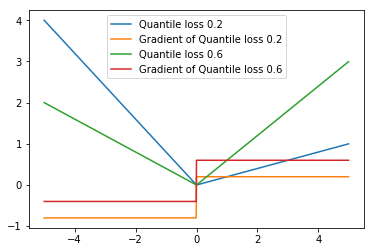

In [5]:
loss = gluon.loss.Quantile(tau=0.2)
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Quantile loss 0.2')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Quantile loss 0.2')

# and now for the same loss function with tau = 0.6 
loss = gluon.loss.Quantile(tau=0.6)

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Quantile loss 0.6')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Quantile loss 0.6')

plt.legend()
plt.show()

## $\epsilon$ Insensitive Loss

In some cases we do not care about small deviations from the truth. More to the point, we do not care about deviations up to $\epsilon$. Beyond that, we might care in a linear fashion. For instance, a screw might have a tolerance of $\epsilon$ and the work to make anything fit beyond that would be linear in the diameter of the screw (yes, it's a contrived example). The associated loss function (described in detail by a paper by Vapnik, Golovich and Smola, 1995) is given by:

$$l(y,f) = \mathrm{max}(0, |y-f| - \epsilon)$$

As you can see, it contains a region $[y-\epsilon, y+\epsilon]$ where the derivative vanishes. Outside that range it is constant. 

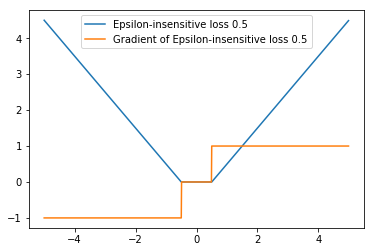

In [6]:
loss = gluon.loss.EpsilonInsensitive(epsilon=0.5)
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Epsilon-insensitive loss 0.5')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Epsilon-insensitive loss 0.5')
plt.legend()
plt.show()

## LogCosh Loss

An obscure variant among loss functions is the LogCosh loss. The key idea is to smooth out the L1 loss such that the loss becomes continuously differentiable even at $0$. This is accomplished by computing the softmax between $y-f$ and $f-y$, i.e. to compute $\log \cosh (y-f)$. The results are exactly as expected. Note that to compute it, we use a numerically stable variant $\log \cosh x = |x| + \log (1+ \exp(-2x))/2$. This ensures that large values of $x$ do not lead to divergent terms.

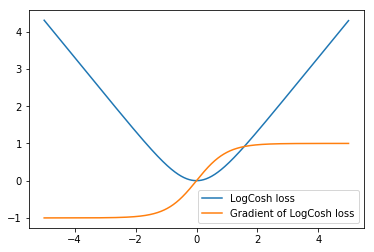

In [7]:
loss = gluon.loss.LogCosh()
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='LogCosh loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of LogCosh loss')
plt.legend()
plt.show()

## Poisson 

In some cases the regression problem does not have to deal with continuous values that could be both positive or negative, but rather with *integer counts*. For instance, the number of rain drops per square meter in a given time, the number of meteorites hitting Antarctica per day, the number of Prussian soldiers that were hit by horses per week, etc. can be useful numbers to estimate. However, it is equally clear that a real valued estimate is useless: we never have 1.3 meteorites. It's only $0, 1, 2, 3, \ldots$ or some other number. Consequently, we need a different loss function. Fortunately the Poisson distribution fits the bill quite well. In it, we assume that 

$$p(y|f) = \frac{1}{y!} \exp(y f - \exp(f)) \text{ and } l(y,f) = - \log p(y|f).$$

In many cases one uses an equivalent formulation with rate parameter $\lambda = \exp(f)$ such that we get
$p(y|\lambda) = \frac{1}{y!} \lambda^y e^{-\lambda}$. Note that this is entirely equivalent. The only problem with the $\lambda$-parametrization is that $\lambda$ must be non-negative, whereas $f$ can assume arbitrary values. **Unlike Keras and PyTorch, Gluon uses the exponential formulation**. 

By design, the loss function vanishes for $y = \exp(f)$, as can be seen in the graph below (this is one of the reasons why sometimes the $\lambda$ parametrization is preferable). 

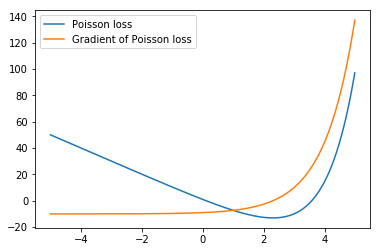

In [8]:
loss = gluon.loss.Poisson()
with ag.record():    # start recording
    theloss = loss(output, 10 * nd.ones_like(output))
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Poisson loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of Poisson loss')
plt.legend()
plt.show()

In [9]:
# this implements an L2 norm triplet loss
# max(margin + |f1 - f2|^2 - |f1-f3|^2, 0) per observation
def TripletLoss(f1, f2, f3):
    margin = 1
    loss = nd.sum((f1-f2)**2 - (f1-f3)**2, axis=1) + 1
    loss = nd.maximum(loss, nd.zeros_like(loss))
    return loss

loss = TripletLoss
#with ag.record():    # start recording
#    theloss = loss(output, nd.ones_like(output))
#theloss.backward()   # and compute the gradient
#plt.plot(output.asnumpy(), theloss.asnumpy(), label='Huber Loss')
#plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient')
#plt.legend()
#plt.show()

f1 = nd.random_normal(shape=(5,10))
f2 = nd.random_normal(shape=(5,10))
f3 = nd.random_normal(shape=(5,10))

theloss = loss(f1, f2, f3)
print(theloss)


[ 7.53516912  0.          0.          0.          6.3003993 ]
<NDArray 5 @cpu(0)>


# Classification 
## Logistic Regression

Next consider the case where we have two labels, say ``cat`` and ``dog``. Since statisticians (and computers) don't like strings, we simplify this to $y \in \{\pm 1\}$. One way of mapping real numbers in $\mathbb{R}$ into class probabilities is to use a sigmoid function.

$$p(y|f) = \frac{1}{1 + \exp(-y f)} \text{ and hence } -\log p(y|f) = \log(1 + \exp(-y f))$$

*Side remark for math nerds:* To keep the term numerically stable we can rewrite it as $-yf + \log(1 + \exp(yf))$ whenever $yf < 0$. The reason for doing this is to avoid exponentiating a large positive number which would trigger a numerical overflow.  Combining both expressions we get the following expression: $\log(1 + \exp(-|yf|)) - \delta(yf < 0) \cdot yf$. As we can see, the probabilities converge to 0 and 1 respectively for extreme values of $f$.

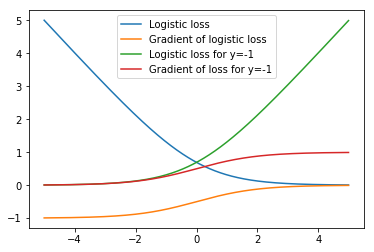

In [10]:
loss = gluon.loss.Logistic()

# getting data ready
thelabel = nd.ones_like(output)
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of logistic loss')
# now compute the loss for y=-1
with ag.record():    # start recording
    theloss = loss(output, -thelabel)
theloss.backward()   # and compute the gradient
plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss for y=-1')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of loss for y=-1')
plt.legend()
plt.show()

## Soft Margin Loss

Note that the logistic loss isn't the only loss that one might encounter. For instance, in Support Vector Machines we have a soft-margin loss. It is $0$ whenever data is correctly classified with some confidence, say $y f(x) > 1$. Otherwise we impose a linear penalty. In math this amounts to

$$l(y,f) = \mathrm{max}(0, 1- yf)$$

In some cases we want to square this loss function. Quite unsurprisingly, the counterpart to `SoftMargin` is called `SquaredSoftMargin`. 

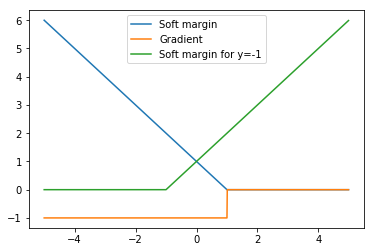

In [11]:
loss = gluon.loss.SoftMargin()

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Soft margin')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient')
# now compute the loss for y=-1
theloss = loss(output, -thelabel)
plt.plot(output.asnumpy(), theloss.asnumpy(), label='Soft margin for y=-1')
plt.legend()
plt.show()

## Exponential Loss

In some cases we *really* want to ensure that things are classified correctly we might replace $\log(1 + \exp(-yf))$ for its exponential counterpart, i.e. $\exp(-yf)$. For instance, AdaBoost can be proven to minimize this loss function when it progressively weighs incorrectly classified data in an exponential way (as an aside, for two loss functions $l_1$ and $l_2$, the gradient $\partial_w l_1(x,f(x))$ and $c \partial_w l_2(x, f(x))$ are identical if $l_1 = c l_2$, hence changing the loss function or reweighting the data are equivalent). No matter, the loss function is available in 'MxNet Gluon' and it implements

$$l(y, f) = \exp(-y f)$$

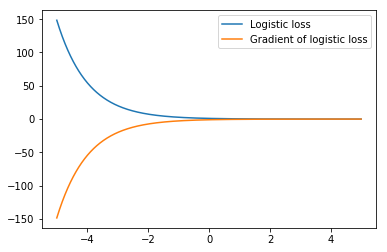

In [12]:
loss = gluon.loss.Exponential()

# getting data ready
thelabel = nd.ones_like(output)
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of logistic loss')
plt.legend()
plt.show()

## Langford's VW loss

One of the more unusual loss functions is John Langford's VW style loss. It is essentially a cut variant of Huber's robust loss, and it works by piecing together a linear, quadratic and constant part of a loss function. The benefit of this choice is that its gradient is bounded for significant misclassification, that its gradient vanishes for highly confident classification and that there is a graduation in terms of how poorly classified data is. We have

$$l(y,f) = \begin{cases}
  0 & \text{ if } 1 < y f \\
  \frac{1}{2} f^2 & \text { if } 0 \leq yf \leq 1 \\
  \frac{1}{2}-yf & \text{ otherwise}
\end{cases}$$

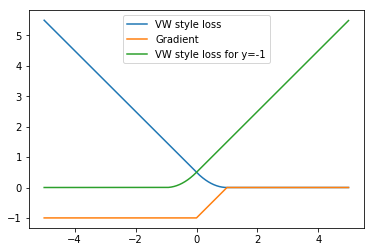

In [13]:
loss = gluon.loss.Langford()

with ag.record():    # start recording
    theloss = loss(output, nd.ones_like(output))
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='VW style loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient')
# now compute the loss for y=-1
theloss = loss(output, -thelabel)
plt.plot(output.asnumpy(), theloss.asnumpy(), label='VW style loss for y=-1')
plt.legend()
plt.show()

# Multiclass Classification 
## Multiclass Softmax

One way of dealing with multiple classes is to turn it into $n$ binary classification problems. That is, we simply test: 'is it class 1', 'is it class 2', ... 'is it class n'. In theory this sounds like a splendid idea. After all, this should be just as easy as determining which class it is. Unfortunately, that's not quite the case. Imagine the situation where none of the $n$ classifiers wants to take responsibility. Or imagine the case where more than one claims that it's his turn. Obviously there has to be a better way. Indeed, there is.

If we have a vector $f \in \mathbb{R}^n$ of scores, where the coordinate, say $f_i$ is large whenever we think that the correct class is $i$, then we can map $f$ into a probability vector via

$$p(y=i|f) \propto \exp(f_i) \text{ and hence } p(y=i|f) = \frac{\exp(f_i)}{\sum_j \exp(f_j)}$$

Here the normalization by $\sum_j \exp(f_j)$ is needed such that all the terms sum up to 1. Consequently the negative log-likelihood $-\log p(y|f)$, i.e. the quantity that we would want to minimize in this case is given by 

$$-\log p(y=i|f) = \log \left[\sum_{j} \exp(f_j)\right] - f_i$$

In ``gluon`` the relevant function is [mxnet.gluon.loss.SoftmaxCrossEntropyLoss](http://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss). Let's check that this is correct.

In [14]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

f = nd.random_normal(shape=(1,10))
y = nd.array([4]) #class 4 is true

print('Softmax loss is {}.'.format(loss(f,y).asscalar()))

# now compute this by hand

p = nd.exp(f)
p = p / nd.sum(p)
print('Class 4 has negative log-likelihood {}.'.format(-nd.log(p[0,4]).asscalar()))

Softmax loss is 1.7977911233901978.
Class 4 has negative log-likelihood 1.7977910041809082.


The softmax loss has a rather nice property that is worth pointing out: its gradient is given by the difference between the conditional class probabilities $p(y=i|f)$ and the indicator vector $e_j$. This can be derived via 

$$\partial_{f_i} \log \sum_j \exp(f_j) = \frac{\exp(f_i)}{\sum_j \exp(f_j)} = p(y=i|f)$$

Such a result seems to be too good to be true by chance. In fact, it holds for *every* member of a larger family of distributions, called the [Exponential Family](https://en.wikipedia.org/wiki/Exponential_family). More specifically, the derivative of the associated normalization is the expected value of the associated embedding. 

## MaxMargin Loss

The soft-margin loss function allowed us to distinguish between two classes with a margin of separation. That is, as long as $y f(x) \geq 1$ we incurred no loss, whereas for smaller values of the margin (and for misclassifications) a loss is incurred. The obvious question is how to generalize this to more than two classes. One possibility is to treat things as many binary classification problems, but this is a bad idea, since tie-breaking can be tricky. An alternative is to require that the correct class be recognized with a safe margin relative to all the other classes as follows: $f(x,y) \geq f(x,y') + 1$ for all $y' \neq y$. Clearly this would do the trick, and we can design a loss function via

$$l(y,f) = \mathrm{max}\left[0, \mathrm{max}_{y' \neq y} \left[f(x,y') - f(x,y) + 1\right]\right]$$

This looks awkward since we have two nested maxima (the outer one is needed to ensure that we don't get negative values for our loss function). A cleaner (albeit slightly wasteful) way of writing this out is to define some function $\Delta(y,y')$ where $\Delta(y,y') = 1$ if $y \neq y'$ and $\Delta(y,y) = 0$. This is a 0-1 loss. In this case the above equation can be rewritten as:

$$l(y,f) = \mathrm{max}_{y'} \left[f(x,y') - f(x,y) + \Delta(y,y')\right]$$

Note that the function $l$ is convex in $f$ (once upon a time when people were using kernels this was a big deal since it meant that the entire optimization problem was convex ...). More importantly for us here is the fact that we now have a parameter, the loss $\Delta$ and an obvious question is what would happen if we changed it a bit. 
Let's take some intuition from the real world. Assume that you're driving on a road with a steep cliff on one side and an incline on the other. 

![](img/road-cliff.jpg)

Any sensible driver will try to stay as far away from the cliff while hugging the shoulder that corresponds to the incline. This is the case since mistakes on the incline are much more benign (scratched rims) than those on the steep cliff (likely death). In other words, a good driver will pick a margin between alternatives that is commensurate with the cost of making a mistake. [Taskar, Guestrin and Koller](http://dl.acm.org/citation.cfm?id=2981349) (TKG) in 2003 realized the same thing and decided to make $\Delta$ cost sensitive (they did lots of other things related to dynamic programming). The result is that the very same loss function as above now allows for misclassification-dependent confidence margins. Obviously this is something that we would also want in our machine learning arsenal. Enter `MaxMargin`. By default it uses the 0-1 loss above (and it automagically infers the size), but if you provide it with a suitable matrix `delta`, it will use the latter. 


In [15]:
# plain vanilla loss 
loss = gluon.loss.MaxMargin()

# some classes (4 class problem)
label = nd.array([1,3,2])
output = nd.random_normal(shape=(3,4))

print('Function values for 3 problems {}'.format(output))
theloss = loss(output, label)
print('Loss function values {}'.format(theloss))
print('Instantiated loss matrix {}'.format(loss._delta))

# now make things more interesting by changing the loss matrix 
delta = nd.array(loss._delta) #call copy constructor
delta[0,3] = 4
delta[1,3] = 4
delta[2,3] = 4
loss = gluon.loss.MaxMargin(delta)
print('Instantiated loss matrix {}'.format(loss._delta))
print('Function values for 3 problems {}'.format(output))
theloss = loss(output, label)
print('Loss function values {}'.format(theloss))

Function values for 3 problems 
[[ 0.84843999  0.85705417 -0.28716376 -0.65270543]
 [-0.56867689 -0.35533145  0.86864537  0.07883889]
 [ 0.50960332  0.80499649 -0.44336858  2.44341731]]
<NDArray 3x4 @cpu(0)>
Loss function values 
[ 0.99138576  1.78980649  3.88678598]
<NDArray 3 @cpu(0)>
Instantiated loss matrix 
[[ 0.  1.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 1.  1.  0.  1.]
 [ 1.  1.  1.  0.]]
<NDArray 4x4 @cpu(0)>
Instantiated loss matrix 
[[ 0.  1.  1.  4.]
 [ 1.  0.  1.  4.]
 [ 1.  1.  0.  4.]
 [ 1.  1.  1.  0.]]
<NDArray 4x4 @cpu(0)>
Function values for 3 problems 
[[ 0.84843999  0.85705417 -0.28716376 -0.65270543]
 [-0.56867689 -0.35533145  0.86864537  0.07883889]
 [ 0.50960332  0.80499649 -0.44336858  2.44341731]]
<NDArray 3x4 @cpu(0)>
Loss function values 
[ 2.49024034  1.78980649  6.88678598]
<NDArray 3 @cpu(0)>


# Information Theory Primer

## Entropy

Sometimes we care about probabilities rather than just labels. In particular, we might want to measure the distance between distributions. For that we need some basics about probabilities, such as the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In a nutshell, the entropy of a random variable is the amount of surprise we encounter each time we sample from it. For instance, the entropy of the constant function is zero, since we already know what's coming. The entropy of a fair coin being tossed is 1 bit. We have no idea what's going to happen (it's a fair coin after all) and there are only two possible outcomes. If we had a biased coin, e.g. one that produces heads with probability 0.9 and tails with probability 0.1, the surprise would be less (after all, most of the time we see a head). Correspondingly its entropy should be lower. On the other hand, a dice with 6 possible outcomes should have a higher degree of surprise. Without further ado, let's define the entropy function:

$$H[p] := \sum_x -p(x) \log p(x)$$

This works well for discrete outcomes. For densities we use

$$H[p] := \int -p(x) \log p(x) dx$$

We can check that for a fair coin the entropy is given by $H[p] = -2 \cdot 0.5 \log 0.5 = \log 2$. Information theorists often measure the information in 'nats' rather than bits. The difference is the base of the logarithm. It's easy to convert: 1 nat is $\log_2 e \approx 1.44$ bit. More generally, for a uniform distribution over $N$ outcomes it is $H[p] = \log N$. One of the fundamental theorems in information theory is that for a distribution $p$, we need at least $H[p]$ nats to encode it. 

There are a number of useful properties for the entropy that are employed in machine learning: 

* Often when estimating distributions we want to find the one with the largest entropy that fits the requirements. That's in line with our desire to restrict our estimates as little as possible beyond what we actually observe.
* The entropy is a concave function. That is, for two distributions $p$ and $q$, the mixture of both has higher entropy: $H[\lambda p + (1-\lambda) q] \geq \lambda H[p] + (1-\lambda) H[q]$. To prove this, simply note that the function $-x \log x$ is concave. 
* When we have independent random variables, say $x$ and $y$, then the entropy of the joint distribution is the sum of the individual entropies. This follows simply from the fact that $\log p(x) q(y) = \log p(x) + \log q(y)$. 
* For dependent random variables the joint entropy is lower than that of the individual terms. This can be seen as follows:

$$\begin{eqnarray}
H[p(x,y)] = & \int -p(x,y) \log p(x,y) \\
= & \int -p(x,y) [\log p(x) p(y)] dx dy + \int p(x,y) \log \frac{p(x) p(y)}{p(x,y)} dx dy \\
\leq & H[p(x)] + H[p(y)] + \log \int p(x,y) \frac{p(x) p(y)}{p(x,y)} dx dy \\
= & H[p(x)] + H[p(y)]
\end{eqnarray}$$

Here the inequality follows from the fact that $\log x$ is a concave function, hence the expectation of the logarithm is less than the logarithm of the expectation. Intuitively this result is straightforward - if $x$ and $y$ are dependent on each other, then knowing $x$ should tell us some more about $y$. Therefore, the joint entropy of $x$ and $y$ should be lower than the sum of the individual entropies. 

This leads us to the notion of mutual information. It is given by the difference between joint and and independent entropies, i.e. $I(x,y) := H[p(x)] + H[p(y)] - H[p(x,y)]$. Basically it's the amount of information that we save. For instance, a light switch and a (functioning) light bulb are strongly correlated - knowing one tells us all about the other. The entropy of the joint is 1 bit (if it's on with probability 0.5), but the sum of the entropies of switch and bulb individually is 2 bit. Hence the mutual information is 1 bit. 

## Kullback Leibler Divergence

This brings us to the KL divergence. It measures how close two distributions are. One way of defining such a quantity is to ask how many extra bits one would have to spend to encode data drawn from $p$ when using a code tuned for $q$. If we assume for a fact that it takes $-\log p(x)$ nat to optimally encode $x$, then the penalty from using the 'wrong' code is given by 

$$D(p\|q) = \sum_x p(x) [\log p(x) - \log q(x)]$$

For densities the quantity is defined analogously, i.e. $\int p(x) [\log p(x) - \log q(x)] dx$. The first thing to prove is that this is actually a distance. For that we need to show that $D(p\|q) \geq 0$ with equality only for $p=q$. To see the latter, simply plug $p=q$ into the definition. To see the former, we rewrite $D$ in the same way as above, using convexity, this time of $-\log x$. 

$$D(p\|q) = \sum_x -p(x) \log \frac{q(x)}{p(x)} \geq -\log \sum_x p(x) \frac{q(x)}{p(x)} = 0$$

As an aside, to see that $H[p]$ can be achieved, indeed, quantize all $p(x)$ into bins of the next largest fraction of $2$, e.g. $0.2$ goes into the bin of $\frac{1}{4}$. It is clear that the sum over those bins is no smaller than $1$ and no larger than $2$. Moreover, we can arrange them into a tree, where at level $l$ the bins are of size $2^{1-l}$. Then we simply index these bins according to their position of the tree. Each $x$ will require $\lceil \log_2 p(x) \rceil$ bits (whatever is left over, we simply discard). In sum this is no more than $\log_2 H[p] + 1$. To tighten the bound, simply send $N$ symbols. Since they can be encoded using at most $N \log_2 H[p] + 1$ bit, the code becomes increasingly efficient with only $1/N$ waste. This proves that such a code can be found. That it's impossible to do any better is a consequence of $D(p\|q) \geq 0$.  
Note that our construction relied on very long codes for efficiency. This is a real problem in practice. [Turbo codes (https://en.wikipedia.org/wiki/Turbo_code) are one of the techniques to address this, e.g. for mobile communications. 

After this long detour, let's finally get to the KL divergence as a loss function. It generalizes the multiclass softmax as follows: instead of having just a single possible true class, it uses a probability distribution as reference. That is

$$\log(f,y) = \sum_i y_i (log(y_i) - f_i)$$

Here $f_i$ is assume to be a probability distribution (or we can set a flag to transform the output into one beforehand). 

In [16]:
loss = gluon.loss.KLDivLoss()

# generate some random probability distribution
f = nd.random_normal(shape=(1,10))
p = nd.exp(f)
p = p / nd.sum(p)

# generate some target distribution
y = nd.random_normal(shape=(1,10))
y = nd.exp(y)
y = y / nd.sum(y)

z = nd.zeros_like(y)
z[0,3] = 1

# distance between our estimate p and the 'true' distribution y
print(loss(nd.log(p), y))
# distance to itself - should be zero
print(loss(nd.log(p), p))
# equivalent of logistic loss with class 3 up to normalization over domain, i.e. 1/10
# note that this is VERY DIFFERENT from information theory but a traditional choice
# in deep learning
print(loss(nd.log(p), z))
print(-nd.log(p[0,3]))


[ 0.05661784]
<NDArray 1 @cpu(0)>

[  1.39972247e-08]
<NDArray 1 @cpu(0)>

[ 0.22255933]
<NDArray 1 @cpu(0)>

[ 2.22559333]
<NDArray 1 @cpu(0)>


## KL Divergence Estimator

Loss functions can also be used for other purposes, such as estimating interesting properties about a distribution. For instance, we might want to *estimate* the KL divergence between two distributions directly. Unfortunately this is difficult, since it requires density estimation and even the ratio between two densities $p(x)/q(x)$ to begin with. A rather neat trick was suggested by [Nguyen, Wainwright and Jordan](http://dept.stat.lsa.umich.edu/~xuanlong/Papers/Nguyen-Wainwright-Jordan-aos09.pdf) (NWJ) in 2009 when they realized that convex duality can be used to estimate such quantities rather directly. Before we dive in, we briefly need to explain what the Fenchel-Legendre dual of a function is:

$$F^*(z) = \mathrm{sup}_x x^\top z - F(x)$$

$f^*$ basically compares a line with slope $z$ to the function $F$ and measures the smallest distance to that line. It has the neat property that its dual is the function itself, i.e. $F^{**} = F$, provided that the function is convex and well-behaved. NWJ used this to derive estimators of the [F-divergence](https://en.wikipedia.org/wiki/F-divergence) between distributions. The latter is defined as 

$$D_F(p\|q) := \int dq(x) F\left(\frac{p(x)}{q(x)}\right)$$

Plugging in duality, we can rewrite this as an optimization problem in terms of $F^*$ (remember, the dual of the dual is the original function, at least for well-behaved convex ones). That is, we obtain

$$\begin{eqnarray}
D_F(p\|q) = & \int dq(x) \sup_G \left[\frac{p(x)}{q(x)} G(x) - F^*(G(x))\right] \\
=& \sup_G \left[\int dp(x) G(x) - \int dq(x) F^*(G(x))\right]
\end{eqnarray}$$

Skipping over details of when and whether this is possible in general, we now have the difference in expectations over two different function - $G(x)$ and $F^*(G(x))$ for two different distributions, namely $p$ and $q$. These can be replaced by empirical estimates (aka sample averages) and it now looks very much like a classification problem, albeit with a weird kind of loss function. In particular, the KL-divergence has $F(x) = x \log x$. After quite some algebra, and a substitution due to the fact that $G$ needs to be non-negative, which lets us set $G(x) = \exp(g(x))$ we arrive at the following problem:

$$D_F(p\|q) = \sup_g \left[\int dp(x) \exp(g(x)) - \int dq(x) (g(x) + 1)\right]$$

This looks just like a classification problem with a weird loss function and with $p$ and $q$ substituted for classes $-1$ and $1$. The 'loss function' `DualKL` in `Gluon` provides this functionality. 


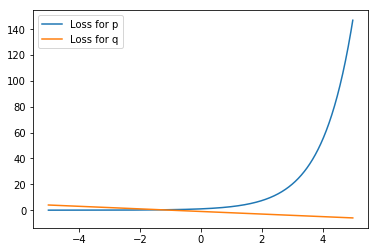

In [17]:
# we broke the output data previously
output = nd.arange(-5,5,0.01)
output.attach_grad() # we need the gradient

loss = gluon.loss.DualKL()

lossp = loss(output, -nd.ones_like(output))
lossq = loss(output, nd.ones_like(output))

plt.plot(output.asnumpy(), lossp.asnumpy(), label='Loss for p')
plt.plot(output.asnumpy(), lossq.asnumpy(), label='Loss for q')
plt.legend()
plt.show()

## Relative Novelty Detection

In some cases estimating a density or even a ratio of densities is not really what we want. Instead, we would like to find the *most typical* or the *most unusual* observation in a dataset. Unfortunately, these things are not really well defined. Before going into measure theory, we need some culinary support. 

|![](img/doughnut.jpg)|![](img/berliner.jpg)|
|:---------------:|:---------------:|
|Doughnut|Jelly Doughnut|

Now imagine that we have two different pastry-shaped distributions - a doughnut shaped one and one that looks like a jelly doughnut (also called 'Berliner' in Europe). These two couldn't be more different from each other. Any data occurring in the donut hole (or far away in its periphery) is novel, whereas for the jelly doughnut only the data far away is novel. Yet we can transform one into the other, simply by messing with the radius in polar coordinates, e.g. via a new radial coordinate $r' = 1/r$. Hence, what once was novel is now no longer novel since we stretched out the center of the poor jelly doughnut so much that its density becomes infinitesimally low. In mathematics terms, this means that novelty is sensitive to the *measure* of the domain where it's defined. This is bad, since we usually don't know this measure. For a 3D space, there are still assumptions of what is considered reasonable (stretching out a poor jelly doughnut probably is not). But for arbitrary domains (database records, books, images, movies, TCP/IP logs) it's pretty hard to define what is reasonable. However, we all know that something that looks just like what we've seen before is probably reasonable ... but that's just like defining what is novely by saying that it's novel if it looks novel. Ouch!

Here's a mathematically more sound way: we use data to define an implicit reference measure. E.g. for server logs we could use past data as a reference measure, such that we can ask the question whether something looks out of order relative to what we've seen in the past. Or for images, whether there's one that stands out relative to past images. Or even for pixels within an image. Mathematically this means that we care mostly about $p(x)/q(x)$ whenever $p(x)/q(x)$ is particularly small. For large ratios things are just fine. This is precisely what [Smola, Le and Teo](http://proceedings.mlr.press/v5/smola09a/smola09a.pdf) (SLT) in 2009 did in their Relative Novelty Detection paper. They used the same reasoning as NGW but with a different F-divergence function: 

$$F\left(\frac{p(x)}{q(x)}\right) = \mathrm{max}\left(0, \rho - \log \frac{p(x)}{q(x)}\right)$$

Here $\rho$ serves as a threshold to decide whether the density ratio is too low. Anything lower than $\exp(\rho)$ is too small. This actually allows us to focus on both the very typical and the very atypical aspects of the data, simply by picking a very small and a very large $\rho$ respectively. Note that for very large $\rho$ this is just the *reverse KL Divergence*, i.e. pretty much the same thing as what NGW were using. Again, skipping over the tedious mathematical details of computing the dual of $F$ and of substituting (we have the same problem of nonnegativity) we arrive at the following loss function:

$$l(y,f) = \begin{cases}
   \exp(f - \rho) & \text{ if } y = -1 \\
   -f-1 & \text{ if } y = 1 \text{ and } f > 0 \\
   \exp(f) & \text{ if } y = 1 \text{ and } f <= 0
\end{cases}$$

'Training' with this loss function will give us precisely the relative novelty detector that we want. All we need to do now is threshold it at $\rho$ to get the desired output. 

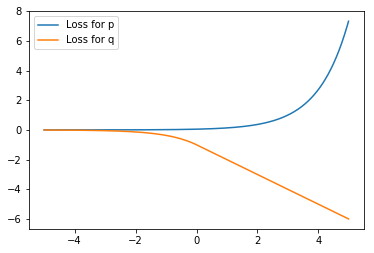

In [18]:
loss = gluon.loss.RelativeNovelty(rho=3)

lossp = loss(output, -nd.ones_like(output))
lossq = loss(output, nd.ones_like(output))

plt.plot(output.asnumpy(), lossp.asnumpy(), label='Loss for p')
plt.plot(output.asnumpy(), lossq.asnumpy(), label='Loss for q')
plt.legend()
plt.show()

# Exotic Losses

There are many loss functions that do not fit into the categories of classification and regression. In fact, there are some recent papers that argue that we should do away with loss functions entirely, such as the one by [Isola, Zhu, Zhou and Efros](https://arxiv.org/abs/1611.07004) from 2016. That said, there are quite a few useful loss functions that are in use. 

## Triplet Loss

Assume that we want to embed data into a vector space. For instance, assume that we want to find embeddings of faces such that faces of the same person are grouped closely together whereas faces of different people are distant. In math: we want $\|f_a - f_{a'}\|$ to be small for $a$ and $a'$ drawn from the same class, whereas we want $\|f_a - f_b\|$ to be large whenever $a$ and $b$ are from different classes. However, this doesn't really tell us *how small* and *how large* we'd really like these distances to be. There is an easy fix - all we need to do is to enforce that the distances are *relatively large*, namely by some constant $c > 0$.  

$$\|f_a - f_{a'}\| + c \leq \|f_a - f_b\|$$

Now we can use the same trick as for soft-margin losses and turn this into a loss function by taking the maximum over the inequality. One last trick is to square the distances such that gradients look nice and we have the triplet loss:

$$l(f_a, f_{a'}, f_b) = \mathrm{max}(0, c + \|f_a - f_{a'}\|^2 - \|f_a - f_b\|^2)$$

Quite unsurprisingly, this is invoked via the `TripletLoss` class. Its constructor lets us adjust the margin $c$ by which data should be separated. Let's generate some data.

In [19]:
loss = gluon.loss.TripletLoss(margin=2)

# make some data. f1 and f2 are similar, f3 is (hopefully) far away
theshape = (5,3)
f1 = nd.normal(shape=theshape)
f2 = nd.normal(shape=theshape)
f3 = nd.normal(shape=theshape) * 5.0

# with the right pair of distances
theloss = loss(f1, f2, f3)
print(theloss)
# these are likely far away in the wrong way, since we blew f3 out of proportions
theloss = loss(f1, f3, f2)
print(theloss)


[ 6.16215515  0.          0.          0.          0.        ]
<NDArray 5 @cpu(0)>

[  0.          36.57266998  51.61498642   9.96375847  32.30460358]
<NDArray 5 @cpu(0)>


Todo - many hierarchical losses, pairwise loss with margin, minimum error decoder, etc.